# Fish Classification using Keras and TensorFlow

## Imports

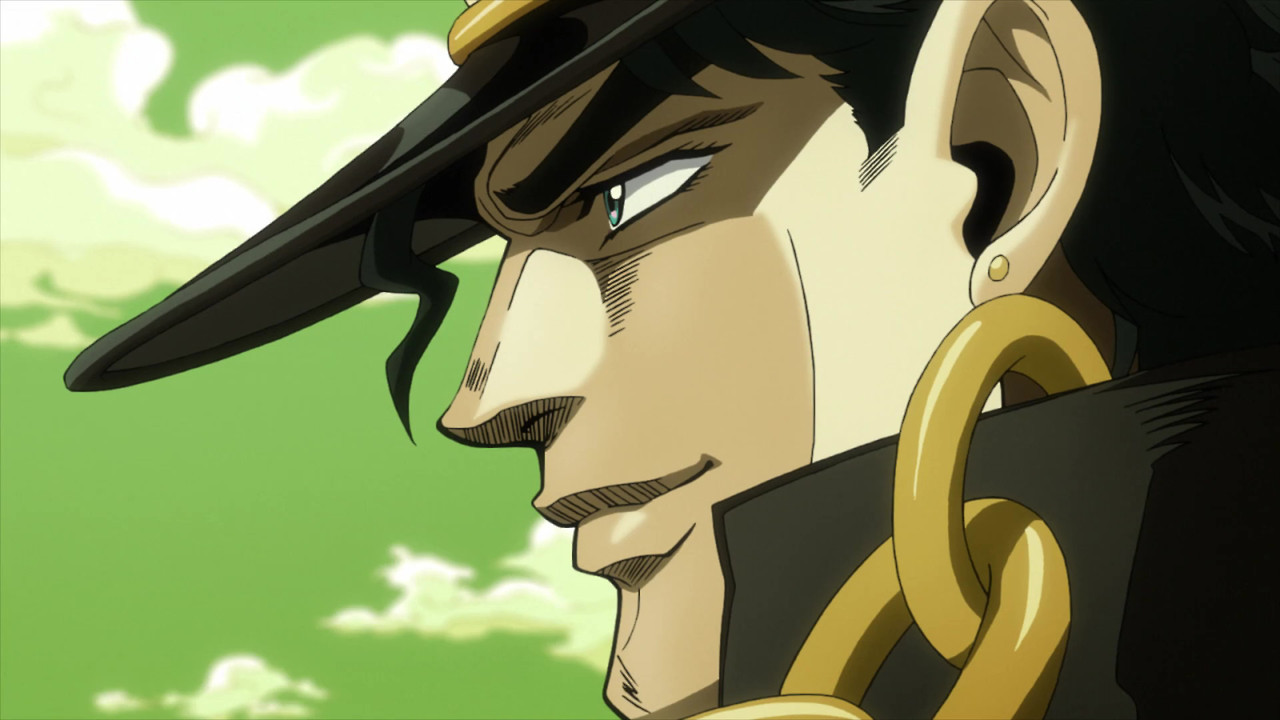

In [2]:
pip install --upgrade tensorflow

     |████████████████████████████████| 489.7 MB 12 kB/s  eta 0:00:01    |█▎                              | 19.8 MB 935 kB/s eta 0:08:23     |███                             | 45.0 MB 686 kB/s eta 0:10:48     |███                             | 46.8 MB 92 kB/s eta 1:19:43     |████                            | 62.1 MB 485 kB/s eta 0:14:41     |██████▎                         | 95.8 MB 283 kB/s eta 0:23:08     |██████▋                         | 100.7 MB 480 kB/s eta 0:13:31     |█████████▉                      | 150.5 MB 548 kB/s eta 0:10:19��████▎                     | 156.8 MB 32 kB/s eta 2:51:34     |███████████                     | 169.3 MB 123 kB/s eta 0:43:17     |████████████▊                   | 195.0 MB 599 kB/s eta 0:08:12     |█████████████▋                  | 208.7 MB 361 kB/s eta 0:12:58     |██████████████▏                 | 216.0 MB 263 kB/s eta 0:17:17     |██████████████▏                 | 216.8 MB 372 kB/s eta 0:12:12     |███████████████▋                | 238.5 MB 285

     |████████████████████████████████| 781 kB 575 kB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 587 kB/s eta 0:00:01    |▍                               | 51 kB 263 kB/s eta 0:00:19
     |████████████████████████████████| 155 kB 356 kB/s eta 0:00:01
     |████████████████████████████████| 97 kB 503 kB/s eta 0:00:01
     |████████████████████████████████| 155 kB 427 kB/s eta 0:00:01
     |████████████████████████████████| 77 kB 501 kB/s eta 0:00:01
     |████████████████████████████████| 146 kB 419 kB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=ff8c81de8fd70d5ea5d367c49a6f1813772707f6c80c3fcd621406e57dcd6db4
  Stored in directory: /home/bogeymantan/.cache/pip/wheels/b6/0d/90/0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

2022-01-22 16:21:58.679008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-22 16:21:58.679037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading the data

In [2]:
direc = Path('Dataset-Images/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths',dtype="str")
Labels = pd.Series(Labels, name='Labels',dtype="str")


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,Dataset-Images/Fish_Dataset/Fish_Dataset/Trout...,Trout
1,Dataset-Images/Fish_Dataset/Fish_Dataset/Hours...,Hourse Mackerel
2,Dataset-Images/Fish_Dataset/Fish_Dataset/Black...,Black Sea Sprat
3,Dataset-Images/Fish_Dataset/Fish_Dataset/Red M...,Red Mullet
4,Dataset-Images/Fish_Dataset/Fish_Dataset/Red M...,Red Mullet


## Displaying Fish

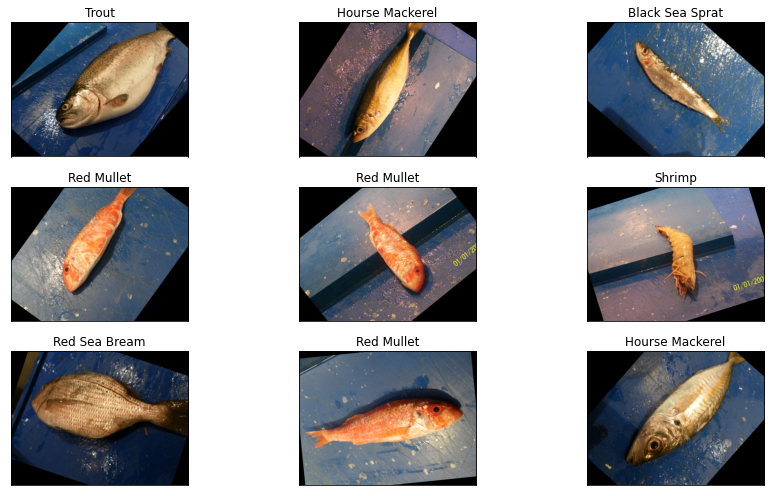

In [3]:


# Showing 9Images 
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()



In [4]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


In [5]:
img_df['Labels'].value_counts(ascending=True)

Trout                 1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Red Mullet            1000
Shrimp                1000
Red Sea Bream         1000
Gilt-Head Bream       1000
Striped Red Mullet    1000
Sea Bass              1000
Name: Labels, dtype: int64

## Splitting dataset

In [6]:


train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()



Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


## Creating and training model

In [7]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [9]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [10]:


Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)



2022-01-22 16:22:38.956337: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2022-01-22 16:22:39.012603: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2022-01-22 16:22:39.030056: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.


Epoch 1/10


2022-01-22 16:22:39.461263: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2022-01-22 16:22:39.476532: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.


211/211 [==============================] - 94s 444ms/step - loss: 1.4831 - accuracy: 0.4533 - val_loss: 1.0624 - val_accuracy: 0.6067
Epoch 2/10
211/211 [==============================] - 86s 405ms/step - loss: 0.9289 - accuracy: 0.6751 - val_loss: 0.7467 - val_accuracy: 0.7256
Epoch 3/10
211/211 [==============================] - 80s 381ms/step - loss: 0.6329 - accuracy: 0.7825 - val_loss: 0.5132 - val_accuracy: 0.8133
Epoch 4/10
211/211 [==============================] - 85s 401ms/step - loss: 0.4570 - accuracy: 0.8456 - val_loss: 0.5207 - val_accuracy: 0.8267
Epoch 5/10
211/211 [==============================] - 80s 380ms/step - loss: 0.3408 - accuracy: 0.8856 - val_loss: 0.3973 - val_accuracy: 0.8689
Epoch 6/10
211/211 [==============================] - 79s 377ms/step - loss: 0.2662 - accuracy: 0.9099 - val_loss: 0.3383 - val_accuracy: 0.8800
Epoch 7/10
211/211 [==============================] - 89s 423ms/step - loss: 0.2114 - accuracy: 0.9244 - val_loss: 0.3646 - val_accuracy: 0.8

In [11]:
print('Model summary :')
print()
fc_model.summary()

Model summary :

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, None)  0         
                                                                 
 flatten_1 (Flatten)         (None, None)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               19267712  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 9

## Accuracy

In [12]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 [==============================] - 14s 317ms/step - loss: 0.2150 - accuracy: 0.9207
Test accuracy is :  92.07407236099243 %


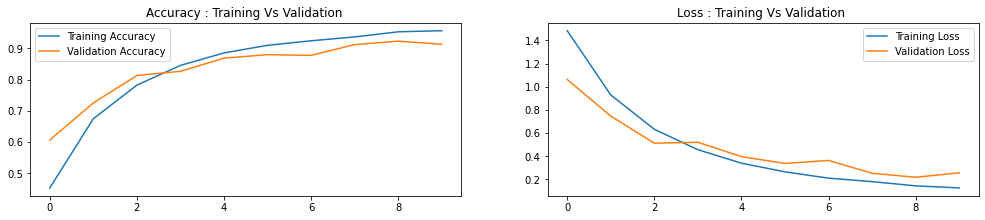

In [13]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

In [14]:
fc_model.save('model')

2022-01-22 16:40:35.325171: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets
